# Problem Set 6
## Nora Nickels
### Perspectives of Computational Modeling
### Winter 2018

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

biden = pd.read_csv('biden.csv', sep=',')
# Drop observations with NaN
biden = biden.dropna()
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


## Problem 1: Decision Trees

### 1a)  Recursive binary splitting

In [2]:
# Define X vars and Y var

print(biden.head())
y = biden['biden'].values
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
print(biden.info())

   biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 98.8 KB
None


In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

# split data into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)

# fit a decision tree with recursive binary splitting

biden_tree1 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5)
biden_tree1.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

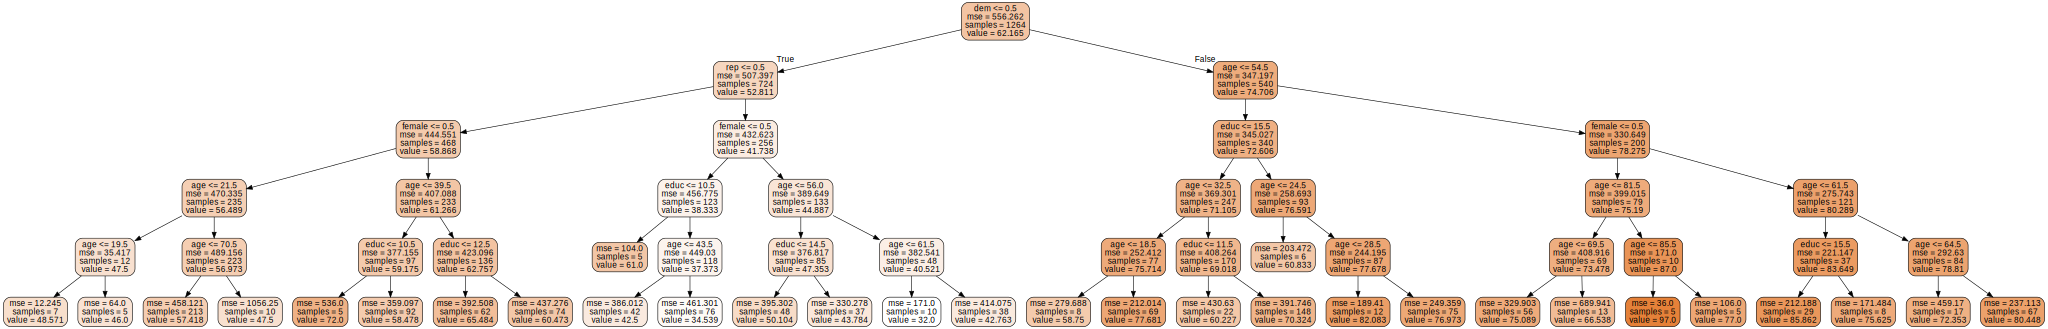

In [5]:
from sklearn.tree import export_graphviz
import graphviz

# plot the decision tree
biden_tree_viz1 = export_graphviz(
    biden_tree1,
    out_file=None,
    class_names = biden_tree1.classes_,
    feature_names = biden.columns[1:],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz1)
graph.render('biden_tree_viz1')
graph

In [6]:
# Get the test MSE
y_pred = biden_tree1.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 411.805927372


### The test MSE is 411.81. According to our tree, the first split happens between democrats and those who are not democrats. Predictably, democrats who identify as democrats like Biden more. For non-democrats, the next split happens with those who identify as republican or not. For those individuals, not identifying as a republican leads to liking Biden more, and for both groups, females like Biden more (with the next split being gender). For democrats, the next split happens with age, with individuals older than 54 liking Biden more, and the next splits being based on gender and education levels. For non-democrats, it seems that identifying as a republican and your gender matter more, and for democrats, your age, gender, and education matter more.

### 1b)  Tree pruning

In [9]:
# Use cross validation to determine the optimal level of tree complexity - AKA, the max depth with the lowest MSE.

for d in range(1,18):
    biden_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=d)
    biden_tree2.fit(X_train, y_train)
    y_pred2 = biden_tree2.predict(X_test)
    MSE2 = mean_squared_error(y_test, y_pred2)
    print('with Max depth = {}; MSE ={}'.format(d, MSE2))

with Max depth = 1; MSE =420.0224529349668
with Max depth = 2; MSE =400.06539818418173
with Max depth = 3; MSE =396.1937146321307
with Max depth = 4; MSE =404.59602362340974
with Max depth = 5; MSE =411.80592737244535
with Max depth = 6; MSE =420.7201303515671
with Max depth = 7; MSE =435.76906119360757
with Max depth = 8; MSE =462.7752812506661
with Max depth = 9; MSE =462.1936150905454
with Max depth = 10; MSE =468.1591455224317
with Max depth = 11; MSE =473.1109721765993
with Max depth = 12; MSE =480.95806248086757
with Max depth = 13; MSE =477.16079264127467
with Max depth = 14; MSE =482.19910500319105
with Max depth = 15; MSE =479.41117593116314
with Max depth = 16; MSE =480.87183478033825
with Max depth = 17; MSE =482.81587206375985


### The optimal tree, AKA the tree with the lowest MSE, has a max depth of 3. The MSE of this tree, which we will plot below and interpret, is 396.20.

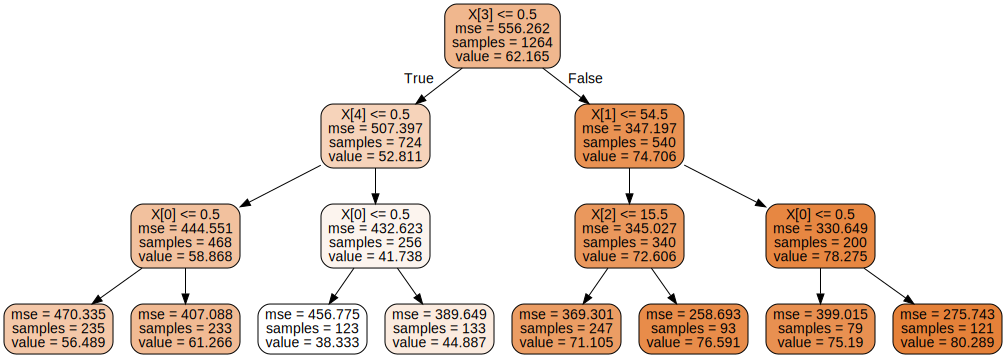

In [10]:
# fit plot the decision tree with the lowest MSE, which is when max depth = 3

biden_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
biden_tree2.fit(X_train, y_train)

biden_tree_viz2 = export_graphviz(
    biden_tree2,
    out_file=None,
    class_names = biden_tree2.classes_,
    feature_names = biden.columns[1:],
    rounded=True,
    filled=True,
)

biden_tree2 = export_graphviz(biden_tree2, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_tree2)
graph.render('biden_tree2')
graph

### The max depth with the lowest MSE is when max depth = 3, so we use that optimal tree to plot our pruned tree. Pruning the tree does improve the test MSE, which has gone from over 400 to now 396. It does appear that the first split still happens between democrats and non-democrats, and that the next splits are similar as well: age for democrats, identifying as a republican or not for non-democrats. The tree are similar, but the depth of the tree ends at three levels, which does lead to the best MSE. So we'll take it!!!

### 1c) Bagging

In [11]:
from sklearn.ensemble import BaggingRegressor

# n_estimators is how many samples from the data to take (the number of trees)
# max_samples is the maximum number of observations to include in each bootstrapped data sample

biden_tree_bag = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)

# hit_tree3 = BaggingRegressor(DecisionTreeRegressor(max_depth=3, min_samples_leaf=5), n_estimators=100,
#                              max_samples=100, bootstrap=True, oob_score=True, random_state=15)

biden_tree_bag.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [12]:
# get MSE of bagging approach model
biden_tree_bag.score(X, y)
y_pred3 = biden_tree_bag.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 406.000558395


In [13]:
# Obtain variable importance of bagging approach model
importances_bag = np.mean([tree.feature_importances_ for tree in biden_tree_bag.estimators_], axis=0)

indices_bag = np.argsort(importances_bag)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances_bag[indices_bag[f]]))

Feature ranking:
1 .  female :  0.442912703961
2 .  age :  0.200576259716
3 .  dem :  0.190323544392
4 .  rep :  0.106028225513
5 .  educ :  0.060159266419


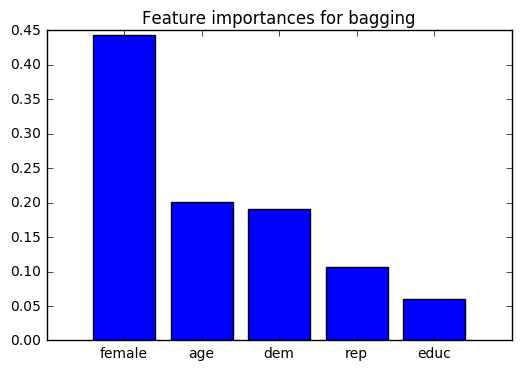

In [14]:
import matplotlib.pyplot as plt

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for bagging")
plt.bar(range(X.shape[1]), importances_bag[indices_bag],
       color="b", align="center")
plt.xticks(range(X.shape[1]), features)
plt.xlim([-1, X.shape[1]])
plt.show()

### The test MSE for a bagging approach is 406.00: better than part a, worse than part b. According to variable importance and the variable importance chart above show that female is the most important variable, followed be age, democratic or not, republican or not, and then education level.

### 1d) Random forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
# the next tree models will use random forest approach
# for m = 1

biden_tree_rf_m1 = RandomForestRegressor(n_estimators=53, max_features= 1, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree_rf_m1.fit(X, y)

biden_tree_rf_m1.score(X, y)
y_pred_m1 = biden_tree_rf_m1.oob_prediction_
MSE_m1 = mean_squared_error(y, y_pred_m1)
print('MSE=', MSE_m1)

MSE= 532.875057972


In [17]:
# for m = 2

biden_tree_rf_m2 = RandomForestRegressor(n_estimators=53, max_features= 2, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree_rf_m2.fit(X, y)

biden_tree_rf_m2.score(X, y)
y_pred_m2 = biden_tree_rf_m2.oob_prediction_
MSE_m2 = mean_squared_error(y, y_pred_m2)
print('MSE=', MSE_m2)

MSE= 538.192542935


In [18]:
# for m = 3

biden_tree_rf_m3 = RandomForestRegressor(n_estimators=53, max_features= 3, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree_rf_m3.fit(X, y)

biden_tree_rf_m3.score(X, y)
y_pred_m3 = biden_tree_rf_m3.oob_prediction_
MSE_m3 = mean_squared_error(y, y_pred_m3)
print('MSE=', MSE_m3)

MSE= 535.761962701


### When m = 1, the MSE = 532. 88. When m = 2, the MSE = 538.20. When m = 3, the MSE = 535.76. The MSE is best when m = 1. Therefore, the error rates is lowest when the number of variables considered at each split is limited to one variable. 

In [19]:
# now get variable importance measures for the three models with RF

importances = biden_tree_rf_m1.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf_m1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking

print("Feature ranking:")

features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

Feature ranking:
1 .  female :  0.512175098628
2 .  age :  0.192432071629
3 .  educ :  0.150180547154
4 .  dem :  0.123879218183
5 .  rep :  0.0213330644052


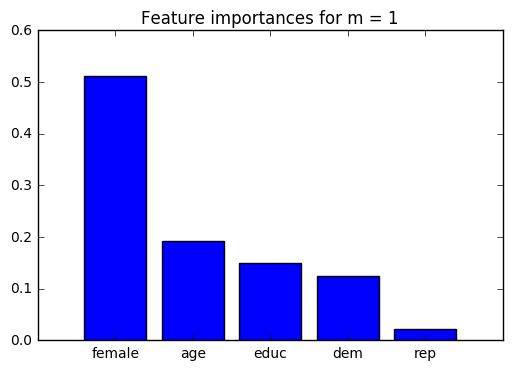

In [20]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for m = 1")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), features)
plt.xlim([-1, X.shape[1]])
plt.show()

In [21]:
importances2 = biden_tree_rf_m2.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf_m2.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking

print("Feature ranking:")

features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances2[indices2[f]]))

Feature ranking:
1 .  female :  0.50758431124
2 .  age :  0.191943514043
3 .  educ :  0.151423695616
4 .  dem :  0.127943907267
5 .  rep :  0.021104571834


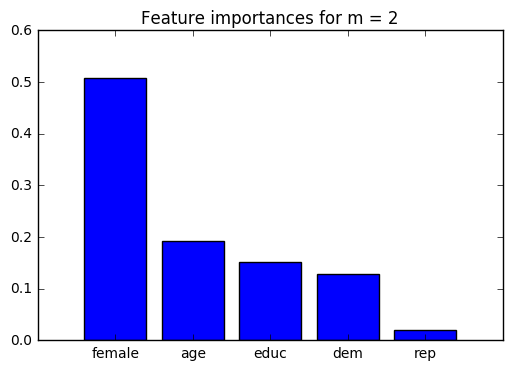

In [22]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for m = 2")
plt.bar(range(X.shape[1]), importances2[indices2],
       color="b", align="center")
plt.xticks(range(X.shape[1]), features)
plt.xlim([-1, X.shape[1]])
plt.show()

In [23]:
importances3 = biden_tree_rf_m3.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf_m3.estimators_],
             axis=0)
indices3 = np.argsort(importances3)[::-1]

# Print the feature ranking

print("Feature ranking:")

features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances3[indices3[f]]))

Feature ranking:
1 .  female :  0.484652036367
2 .  age :  0.199165322239
3 .  educ :  0.165089462362
4 .  dem :  0.123722379345
5 .  rep :  0.0273707996866


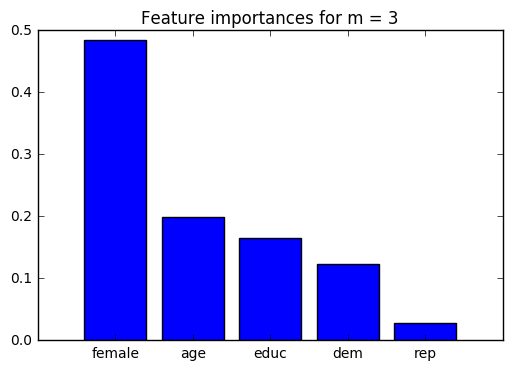

In [24]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for m = 3")
plt.bar(range(X.shape[1]), importances3[indices3],
       color="b", align="center")
plt.xticks(range(X.shape[1]), features)
plt.xlim([-1, X.shape[1]])
plt.show()

### For m = 1, m = 2, and m = 3, the order of variable importance is the same: female, age, educ, dem, and rep.